### Import Libraries

In [2]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models


from sklearn.model_selection import KFold

from sklearn.metrics import precision_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import time

### Helper Functions

Define some helper functions which will come in handy later.

In [3]:
def plot_images(images_arr, labels_arr, dim=(3, 3)):
    
    """
    Plots an array of images and their corresponding labels.
    
    :param images_arr: Array of images
    :param labels_arr: Array of labels which correspond in order to the images
    :param dim: Dimensions of the plot in terms of number of images
    """

    fig, axes = plt.subplots(dim[0], dim[1], figsize=(6, 6))
    axes = axes.flatten()
    i = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.squeeze(img), aspect='auto')
        ax.set_xlabel(class_names[labels_arr[i]])
        i += 1
    plt.tight_layout()
    plt.show()


def create_activation_model(model):
    
    """
    Converts model into a format that allows visualization of the intermediate layers.
    
    :param model: Tensorflow model
    """

    # Extract output from top four layers
    layer_outputs = [layer.output for layer in model.layers[:5]]

    # Construct model to output intermediate activations
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    return activation_model


def display_activation(activations, col_size, row_size, act_index):
    
    """
    Displays the intermediate activation layer of the CNN.
    
    :param activations: The result of predicting with the activation model.
    :param col_size: column dimension
    :param row_size: row dimension
    :param act_index: Index into an intermediate layer
    """

    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

def class_grid(X, y, class_num):
    
    """
    Show a chunk of data from a particular class.
    
    :param X: Array of images in dataset
    :param y: Array of labels in dataset
    :param class_num: Class label (integer)
    """

    X = X[y == class_num][0:64]

    plt.figure(figsize=(5, 5))
    for i, image in enumerate(X):
        plt.subplot(8, 8, i + 1)
        plt.axis("off")
        plt.imshow(image[:, :, 0], aspect='auto')

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()


def remap(x, oldMin, oldMax, newMin, newMax):
    
    """
    Remap a piece of data from one range to another.
    
    :param x: scalar number
    :param oldMin: Minimum of old range
    :param oldMax: Maximum of old range
    :param newMin: Minimum of new range
    :param newMax: Maximum of new range
    """
    
    old_range = oldMax - oldMin
    new_range = newMax - newMin
    x = (((x - oldMin) * new_range) / old_range) + newMin
    return x


def shuffle_in_unison(X, y):
    
    """
    Randomly shuffles data and labels in unison.
    
    :param X: Images
    :param y: Labels
    """
    
    rng_state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(rng_state)
    np.random.shuffle(y)
    return X, y

### Import the Labeled Dataset

The labeled dataset (calls, noiise samples, and validation set) is saved away in pickle files. Here we import then and use then as arrays.

In [5]:
f1 = open("D:/WHOI Storage/data/train", "rb")
X_train = pickle.load(f1)
y_train = pickle.load(f1)
f1.close()

f2 = open("D:/WHOI Storage/data/validation", "rb")
X_val = pickle.load(f2)
y_val = pickle.load(f2)
f2.close()

f3 = open("D:/WHOI Storage/data/noise/noise", "rb")
X_noise = pickle.load(f3)
y_noise = pickle.load(f3)
y_noise = y_noise.astype(int)
f3.close()

# Add channel dimension
X_train = X_train[:, :, :, np.newaxis]
X_val = X_val[:, :, :, np.newaxis]
X_noise = X_noise[:, :, :, np.newaxis]
X_hard_negs = X_hard_negs[:, :, :, np.newaxis]

# Concatenate train, validation, and noise data because we're using K-fold cross validation
X = np.concatenate((X_train, X_val, X_noise), axis=0)
y = np.concatenate((y_train, y_val, y_noise), axis=0)

# Define array of class names
class_names = ['other', 'disp_2', 'noise']

Take a look at some sample images.

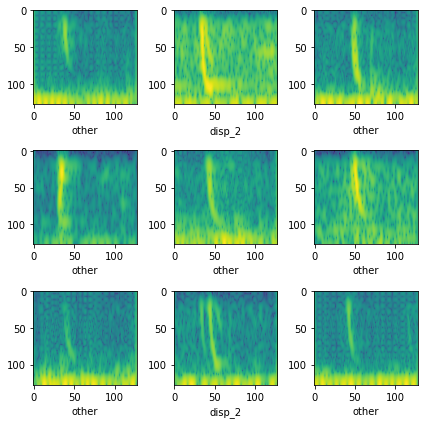

In [6]:
plot_images(X[:9], y[:9], dim=(3, 3))

Here we can view a chunk of data from specific classes.

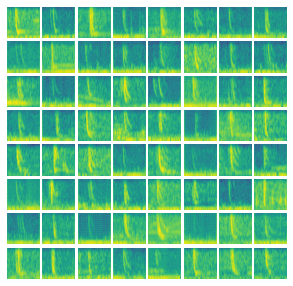

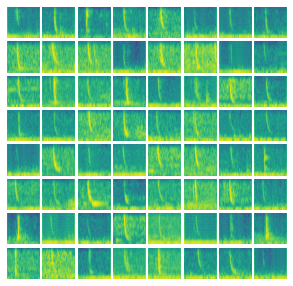

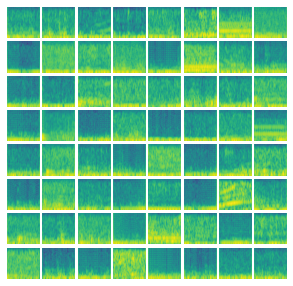

In [10]:
disp_num = class_names.index('disp_2')
other_num = class_names.index('other')
noise_num = class_names.index('noise')

class_grid(X, y, disp_num)

class_grid(X, y, other_num)

class_grid(X, y, noise_num)

### Preprocess Data

In [ ]:
for i in range(len(X)):
    
    # Rescale data between 0 and 1
    X[i] = remap(X[i], np.min(X[i]), np.max(X[i]), 0, 1)


# Shuffle the data
X, y = shuffle_in_unison(X, y)

### Prepare the Model

Create arrays that will store the training meta data.

In [11]:
# Define per-fold score containers and histories
acc_per_fold = []
loss_per_fold = []
history_per_fold = []
precision_per_fold = []
epochs_per_fold = []
prec = []

# Save correct/incorrect validation indices and
# validation set indices
val_sets = []
corr_ind = []
incorr_ind = []

# Save models
models_per_fold = []

Define parameters for the model and define the image generators.

In [12]:
BATCH_SIZE = 32  # Number of training examples to process before updating model parameters
IMG_SHAPE = 128  # Data consists of images 1024 X 632 pixels
NUM_FOLDS = 5  # Define `K` for the K-fold cross-validation

train_image_generator = ImageDataGenerator(width_shift_range=[0, -14], fill_mode='wrap')
validation_image_generator = ImageDataGenerator()

### Define and Train the Model

In [ ]:
# Keep track of the fold
fold_no = 1

# K-fold object
kf = KFold(n_splits=NUM_FOLDS, shuffle=True)

# Train and evaluate the model on each fold
for train, val in kf.split(X):

    # Define the model
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(3)
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Generate training and validation sets
    train_data_gen = train_image_generator.flow(X[train], y[train], batch_size=BATCH_SIZE, shuffle=True)
    val_data_gen = validation_image_generator.flow(X[val], y[val], batch_size=BATCH_SIZE, shuffle=False)
    
    print("--------------------------------------------------------------------------------")
    print("Training for fold {} ...".format(fold_no))

    # Set up tensorboard
    # log_name = "C:/Users/mgoldwater/ssf_goldwater/logs_{}".format(fold_no)
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_name, histogram_freq=10, write_images=True)

    # Train the model
    EPOCHS = 100
    history = model.fit(
                train_data_gen,
                steps_per_epoch=int(np.ceil(len(train) / float(BATCH_SIZE))),
                epochs=EPOCHS,
                validation_data=val_data_gen,
                #callbacks=[tensorboard_callback]
    )

    # calculate fold loss/accuracy
    loss_acc = model.evaluate(val_data_gen, verbose=0)

    # calculate fold precision
    y_pred = model.predict(val_data_gen)
    y_pred = np.argmax(y_pred, axis=1)
    prec = precision_score(y[val], y_pred, average=None)

    # store indices for correct and incorrect validation predictions
    val_sets.append(val)
    corr_ind.append(y_pred == y[val])
    incorr_ind.append(y_pred != y[val])

    # Report and store fold metrics
    print("Fold {} --> val_loss: {} - val_accuracy: {} - val_precision: {} - epochs: {}".format(fold_no, loss_acc[0], loss_acc[1], prec, len(history.history['loss'])))
    acc_per_fold.append(loss_acc[1] * 100)
    loss_per_fold.append(loss_acc[0])
    history_per_fold.append(history)
    precision_per_fold.append(prec * 100)
    epochs_per_fold.append(len(history.history['loss']))
    models_per_fold.append(model)

    # Iterate fold number
    fold_no += 1

# Provide average scores
print("--------------------------------------------------------------------------------")
print("Scores per fold")
for i in range(len(acc_per_fold)):
    print("Fold {} --> loss: {} - accuracy: {} - precision: {} - epochs: {}".format(i + 1, loss_per_fold[i], acc_per_fold[i], precision_per_fold[i], epochs_per_fold[i]))
print("--------------------------------------------------------------------------------")
print("Average scores for all folds")
print("loss: {} - accuracy: {} - precision: {} - epochs: {}".format(np.mean(loss_per_fold), np.mean(acc_per_fold), np.mean(precision_per_fold, axis=0), np.mean(epochs_per_fold)))
print("--------------------------------------------------------------------------------")

### Analyze the Performance of the Model

Plot the training and validation loss and accuracy for each fold.

In [ ]:
for i in range(len(history_per_fold)):

    history = history_per_fold[i]

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, '-o', label="Training Accuracy")
    plt.plot(epochs_range, val_acc, '-o', label="Validation Accuracy")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, '-o', label="Training Loss")
    plt.plot(epochs_range, val_loss, '-o', label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Pick a fold to analyze further.

In [ ]:
fold_no = 1

Separate the validation images for a given fold into those that were labeled correctly and those that were not.

In [ ]:
# Get validation set and respective labels
val_set_imgs = X[val_sets[fold_no - 1]]
val_set_lbls = y[val_sets[fold_no - 1]]

# Get correct images and respective labels
corr_imgs = val_set_imgs[corr_ind[fold_no - 1]]
corr_lbls = val_set_imgs[corr_ind[fold_no - 1]]

# Get incorrect images and respective labels
incorr_imgs = val_set_imgs[incorr_ind[fold_no - 1]]
incorr_lbls = val_set_lbls[incorr_ind[fold_no - 1]]

Plot some of the incorrectly classified validation images.

In [ ]:
# Run incorrectly classified images through the network
y_pred = models_per_fold[fold_no - 1].predict(incorr_imgs)
y_pred = np.argmax(y_pred, axis=1)

# Plot results
plot_images(incorr_imgs[0:9], y_pred[0:9], dim=(3, 3))

Plot confusion matrix.

In [ ]:
y_pred = models_per_fold[fold_no - 1].predict(val_set_imgs)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(val_set_lbls, y_pred)

plt.figure(figsize=(10, 8))
ax = plt.axes()
categories = ['1 modes', '≥ 2 modes', 'no call']
sns.heatmap(cm, annot=True, fmt="d", ax=ax, transparent=True)
ax.set_xticklabels(categories, rotation=45, size=13)
ax.set_yticklabels(categories, rotation=45, size=13)

### Plot Intermediate Activations

In [ ]:
# Create activation model to look at intermediate activations
activation_model = create_activation_model(models_per_fold[fold_no - 1])

# Set image that was incorrectly labeled and activation layer
image_num = 10
activation_layer = 4

# Plot original image
plt.imshow(incorr_imgs[image_num][:, :, 0])
plt.xlabel(class_names[incorr_lbls[image_num]])
plt.show()

# Plot activations
activations = activation_model.predict(incorr_imgs[image_num].reshape(1, IMG_SHAPE, IMG_SHAPE, 1))
display_activation(activations, 4, 4, activation_layer)

### Train the Model on all the Data

Train the model.

In [ ]:
 Define the model
model = tf.keras.models.Sequential([

    # tf.keras.layers.Conv2D(8, (9, 9), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(3)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Generate training and validation sets
train_data_gen = train_image_generator.flow(X, y, batch_size=BATCH_SIZE, shuffle=True)

# Train the model
EPOCHS = 34
history = model.fit(
            train_data_gen,
            steps_per_epoch=int(np.ceil(len(X) / float(BATCH_SIZE))),
            epochs=EPOCHS
)

Save the model to reuse later.

In [ ]:
# Use time to name the model
t = time.time()

# Save
export_path_keras = "models/{}.h5".format(int(t))
model.save(export_path_keras)